### Import Packages


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *


Using TensorFlow backend.


### Read in datafile and Extract input and labels


In [111]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

X_train, X_test, y_train, y_test = train_test_split(train_input, train_labels, test_size=0.15, shuffle = True, random_state = 255)

(7380, 7)
(2460, 2)
0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


In [86]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

def schedule(ind):
    a = [0.001, 0.0005, 0.0001, 0.0001]
    return a[ind] 

### Tokenise and pad

In [112]:
max_features = 100000
maxlen = 100
embed_size = 100

print('preprocessing start')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test) + list(test_input))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


preprocessing start
Found 4620 unique tokens.


### Create embedding dictionary and matrix

In [113]:
### Read pkl file provided
import gc
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    embeddings_index = pickle.load(g)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print('preprocessing done')


C:\Users\lim_k\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


preprocessing done


In [114]:
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 512
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)


In [115]:
comment = Input(shape=(maxlen,))
emb_comment = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)

resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
resize_emb = PReLU()(resize_emb)
    
block1_output = add([block1, resize_emb])
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

In [116]:
block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
    
block3_output = add([block3, block2_output])
block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)
block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)

block4_output = add([block4, block3_output])
block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

In [117]:
block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)
block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)

block5_output = add([block5, block4_output])
block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)
block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)

block6_output = add([block6, block5_output])
# block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

block6_output = add([block6, block6_output])
output = GlobalMaxPooling1D()(block6_output)

output = Dense(dense_nr, activation='relu')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(5, activation='sigmoid')(output)

model = Model(comment, output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 100, 100)     462100      input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 100, 100)     0           embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 100, 64)      19264       spatial_dropout1d_6[0][0]        
____________________________________________________________________________________________

In [118]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])
            
batch_size = 128
epochs = 15

Xtrain, Xval, ytrain, yval = train_test_split(x_train, y_train, train_size=0.90, random_state=233, shuffle = True)

lr = callbacks.LearningRateScheduler(schedule)
ra_val = RocAucEvaluation(validation_data=(Xval, yval), interval = 1)
history = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, yval),verbose=1, shuffle = True)

Train on 5645 samples, validate on 628 samples
Epoch 1/15
5645/5645 [==============================] - 13s 2ms/sample - loss: 0.7113 - accuracy: 0.6304 - val_loss: 0.6703 - val_accuracy: 0.6360
Epoch 2/15
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.6551 - accuracy: 0.6498 - val_loss: 0.6589 - val_accuracy: 0.6561
Epoch 3/15
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.6229 - accuracy: 0.6603 - val_loss: 0.6417 - val_accuracy: 0.6433
Epoch 4/15
5645/5645 [==============================] - 10s 2ms/sample - loss: 0.5924 - accuracy: 0.6762 - val_loss: 0.6363 - val_accuracy: 0.6430
Epoch 5/15
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.5613 - accuracy: 0.6952 - val_loss: 0.6262 - val_accuracy: 0.6449
Epoch 6/15
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.5330 - accuracy: 0.7144 - val_loss: 0.6028 - val_accuracy: 0.6697
Epoch 7/15
5645/5645 [==============================] - 9s 2ms/sample - los

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


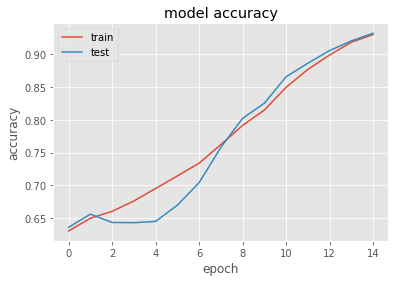

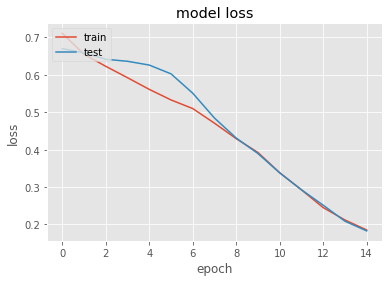

In [119]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
yhat = model.predict(x_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]
type(preds_labels)

list

In [124]:
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

print(multilabel_confusion_matrix(y_test, preds_labels))

print(average_precision_score(y_test, preds_labels))
print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(y_test, preds_labels))

[[[605  18]
  [175 309]]

 [[569  52]
  [ 45 441]]

 [[461  36]
  [ 51 559]]

 [[915   2]
  [ 10 180]]

 [[914   0]
  [ 13 180]]]
0.882222926690414
0.8925133689839573
ROC-AUC Score: 0.915499751178646


### Preparing for submission

In [125]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

(7380, 7)
(2460, 2)
0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


In [126]:
max_features = 100000
maxlen = 100
embed_size = 100

print('preprocessing start')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_input)+ list(test_input))

X_train = tokenizer.texts_to_sequences(train_input)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(test_input)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

### Read pkl file provided
import gc
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    embeddings_index = pickle.load(g)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print('preprocessing done')

preprocessing start
Found 4620 unique tokens.


C:\Users\lim_k\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


preprocessing done


In [128]:
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 512
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)



comment = Input(shape=(maxlen,))
emb_comment = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)

resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
resize_emb = PReLU()(resize_emb)
    
block1_output = add([block1, resize_emb])
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
    
block3_output = add([block3, block2_output])
block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)
block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)

block4_output = add([block4, block3_output])
block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)
block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)

block5_output = add([block5, block4_output])
block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)
block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='relu', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)

block6_output = add([block6, block5_output])
# block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

block6_output = add([block6, block6_output])
output = GlobalMaxPooling1D()(block6_output)

output = Dense(dense_nr, activation='relu')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(5, activation='sigmoid')(output)

In [129]:
model = Model(comment, output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 100, 100)     462100      input_17[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_8 (SpatialDro (None, 100, 100)     0           embedding_14[0][0]               
__________________________________________________________________________________________________
conv1d_144 (Conv1D)             (None, 100, 64)      19264       spatial_dropout1d_8[0][0]        
____________________________________________________________________________________________

In [130]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam',
            metrics=['accuracy'])
            
batch_size = 128
epochs = 50

history = model.fit(x_train[:-150], train_labels[:-150], batch_size=batch_size, epochs=epochs,
                    validation_data=(x_train[-150:], train_labels[-150:]),verbose=1, shuffle = True)

Train on 7230 samples, validate on 150 samples
Epoch 1/50
7230/7230 [==============================] - 17s 2ms/sample - loss: 0.7085 - accuracy: 0.6266 - val_loss: 0.6769 - val_accuracy: 0.6440
Epoch 2/50
7230/7230 [==============================] - 12s 2ms/sample - loss: 0.6317 - accuracy: 0.6620 - val_loss: 0.6520 - val_accuracy: 0.6307
Epoch 3/50
7230/7230 [==============================] - 13s 2ms/sample - loss: 0.5929 - accuracy: 0.6804 - val_loss: 0.6414 - val_accuracy: 0.6307
Epoch 4/50
7230/7230 [==============================] - 13s 2ms/sample - loss: 0.5454 - accuracy: 0.7077 - val_loss: 0.6251 - val_accuracy: 0.6347
Epoch 5/50
7230/7230 [==============================] - 12s 2ms/sample - loss: 0.4920 - accuracy: 0.7498 - val_loss: 0.5498 - val_accuracy: 0.6960
Epoch 6/50
7230/7230 [==============================] - 13s 2ms/sample - loss: 0.4113 - accuracy: 0.8079 - val_loss: 0.4350 - val_accuracy: 0.8027
Epoch 7/50
7230/7230 [==============================] - 13s 2ms/sample 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


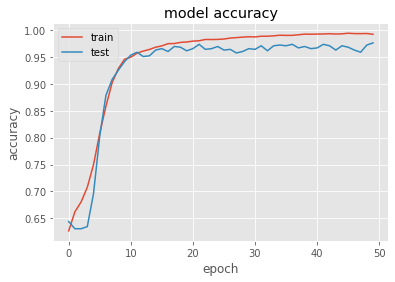

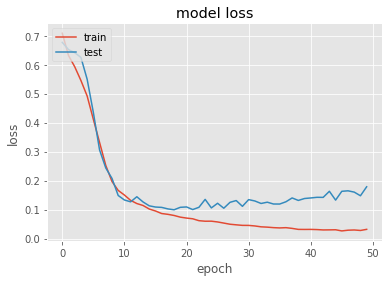

In [131]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
yhat = model.predict(x_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [133]:
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission4.csv',index = False)